In [1]:

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
sys.path.append(os.path.abspath("../lib"))
from all import all_in_one
from show import show_hyperparam_opti
from train import iterate_params, choose_params, nb_possibility
from prepare_data import make_cut, to_categorical


In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_emission', 'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(
    F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# ML

In [6]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint

In [9]:
col_X_hot = [[]]
col_y = ['surface']
col_X_not_hot = [[col[0]
                  for col in training_surf.dtypes if col[0] not in col_X_hot + col_y]]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': randint(100,1000),
        'class_weight': ['balanced'],
    }
]
models = {
    'logistic': LogisticRegression
}
cut_params = {
    'first_value': [30, 40, 50, 60, 70],
    'steps': [25, 35, 45, 55, 65],
    'nb_steps': [1, 2, 3]
}

current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
# register score
best_models = all_in_one(categorical_surf, dictionary, [], col_X_hot, col_X_not_hot, col_y, False,
                         True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
max_score = deepcopy(best_models['RandomForestClassifier'][1])
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * best_models['RandomForestClassifier'][1]
print(score_corrected)
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])
       ] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
    best_models = all_in_one(categorical_surf, dictionary, [], col_X_hot, col_X_not_hot, col_y, False,
                             True, hyperparams_models, models, random_state=42, test_size=0.4, show=False)
    score_corrected = coef * best_models['RandomForestClassifier'][1]
    print(score_corrected)
    scores[tuple([param for param in current_params.values()])
           ] = deepcopy(score_corrected)
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

75
0.8824074074074073 {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 97}
0.10168928976728417
0 [1, 0, 0]
0.8523148148148147 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 96}
0.16076292169606926
0.8165895061728395 {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 101}
0.24877872102106077
0.7776234567901235 {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 95}
0.3428598448561308
0.7277777777777777 {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 97}
0.43504487774682754
0.878858024691358 {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 95}
0.15122093508815881
0.8366512345679011 {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 109}
0.2201994136662195
0.7872685185185185 {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 92}
0.3095816752884998
0.6997685185185185 {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 91}
0.3734140801167263
0.6124228395061728 {'class_weight': 'balanced

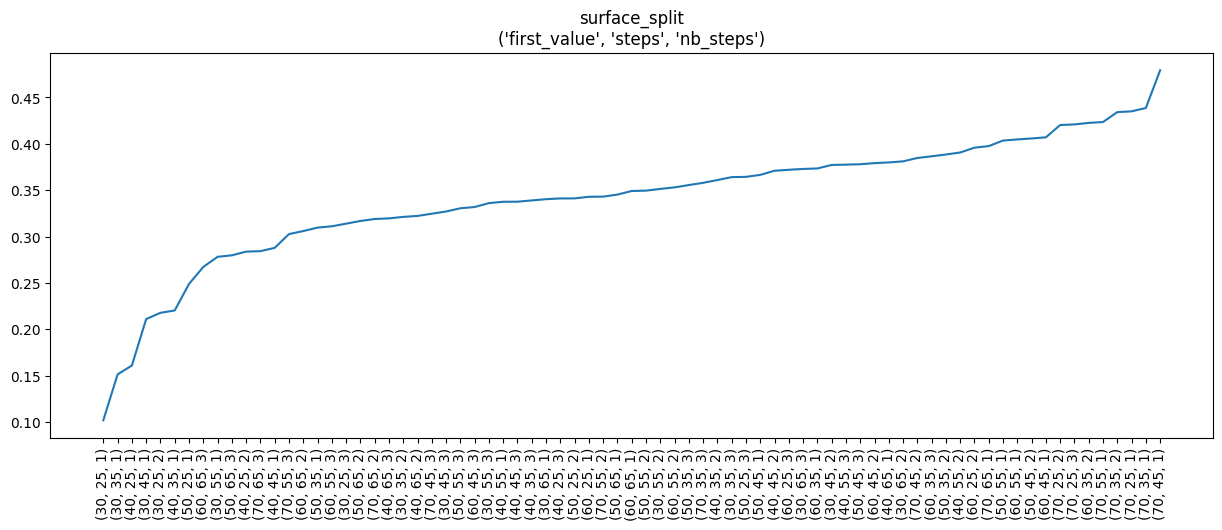

In [10]:
f, ax_hyper = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
show_hyperparam_opti(scores, cut_params, ax_hyper, 'surface_split')
plt.show()